# COVID-19 Analysis

## Table of Contents
1. [About the authors](#About-the-authors)
    1. [Abdullah Chaudhry](#Abdullah-Chaudhry)
    2. [Claudia Raffaelli](#Claudia-Raffaelli)
2. [Introduction to the dataset](#Introduction-to-the-dataset)
3. [Getting Started](#Getting-started)
4. [Familiarizing with the dataset](#Familiarizing-with-the-dataset)
    1. [Provinces JSON](#Provinces-JSON)
    1. [Regions JSON](#Regions-JSON)
5. [Province Analysis](#Province-analysis)
6. [Region Analysis](#Region-analysis)
7. [Province and Region Analysis](#Province-and-Region-Analysis)


## About the authors

#### Abdullah Chaudhry
- Personal GitHub: https://github.com/chabdullah
- Operating System: Ubuntu 20.04 LTS
- Computer: Huawei Matebook D 14
- Processor: AMD Ryzen 5 2500U
- RAM: 8GB
- Storage: 250GB SSD + 1TB HDD
----
#### Claudia Raffaelli
- Personal GitHub: https://github.com/ClaudiaRaffaelli
- Operating System: macOS Catalina
- Computer: MacBook Pro
- Processor: 2,8 GHz Intel Core i7 quad-core
- RAM: 16GB
- Storage: 1TB SSD

## Introduction to the dataset

The analysis proposed hereafter have the purpose of uncovering the various aspects that links the cases of COVID-19 to the different regions and provinces of Italy. This work is based upon the dataset at the link [COVID-19](https://github.com/pcm-dpc/COVID-19), made available by the "Protezione Civile Italiana" organization.

The dataset under consideration has a wide repository structure, although we will just make use of two JSON files, related to the province and region data, largely discussed below. 

The COVID-19 dataset has been collecting a broad amount of data, since the beginning of the spread of the coronavirus in Italy. For this reason the gathered data, dates back to the end of February 2020 and still continues to be collected (at least as we speak, 2020-05-27).

The dataset is updated daily with the new data regarding for example the national, regional and province trends. Most of the commits add new records concerning the past day.

There are two major contributors to this project under the names: [Umbros](https://github.com/umbros) and [Pierluigicara](https://github.com/pierluigicara) in the department of Protezione Civile Italiana already mentioned.


## Getting started

As first thing, we make sure that our system satisfies the main prerequisites required to run the following code. In order to do so, we execute the subsequent Terminal commands (recognizable by the bang symbol <code>!</code>). This commands will check, and if necessary install, a few libraries.

In [1]:
!pip install matplotlib
!pip install networkx
!pip install numpy
!pip install pandas
!pip install geopandas
!pip install descartes

/usr/bin/sh: 1: pip: not found
/usr/bin/sh: 1: pip: not found
/usr/bin/sh: 1: pip: not found
/usr/bin/sh: 1: pip: not found
/usr/bin/sh: 1: pip: not found
/usr/bin/sh: 1: pip: not found


Importing below the required libraries used for the analysis.

In [2]:
import json
import geopandas as gpd
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
from shapely.geometry import Point, Polygon
from pyproj import CRS

## Familiarizing with the dataset

To conduct the analysis we will be using two JSON file that are briefly described hereunder. 

### Provinces JSON
The first file taken into account can be reached at [this link](https://github.com/pcm-dpc/COVID-19/blob/master/dati-json/dpc-covid19-ita-province.json). Hereafter we will be referring at the collected data from this file as provinces data. 

TODO: aggiungi info
... spiegare il perché sono presenti record in <code>denominazione_provincia</code> con scritto <code>In fase di definizione/aggiornamento</code>. ABDULLAH: "prendo quello che c'è sul loro github:"

The autonomous provinces of Trento and Bolzano are indicated in <code>denominazione_provincia</code> and with the code 04 of Trentino Alto Adige. Each Region has a Province called <code>In fase di definizione/aggiornamento</code> with the province code from 979 to 999, useful for indicating data not yet assigned to the Provinces

### Regions JSON
The Regions file, on the other hand, can be found at [this other link](https://github.com/pcm-dpc/COVID-19/blob/master/dati-json/dpc-covid19-ita-regioni.json). The data drawn from the region file will be henceforth called regions data.

TODO: aggiungi info

Now that the main features from the two files have been described, is time to load the two files and get started with the assessment.

In [3]:
with open('./dati-json/dpc-covid19-ita-province.json') as f:
    covid19_provinces_data = json.load(f)

with open('./dati-json/dpc-covid19-ita-regioni.json') as f:
    covid19_regions_data = json.load(f)

## Province analysis

Once the province data has been loaded we want to quickly show how the raw data appears with just a few refinements.
The modifications adopted are the following:
1. First is created a DataFrame <code>refined_province_data</code> in which some unnecessary columns are dropped. 
2. Morover, since inside the columm <code>denominazione_provincia</code> are present a few records labeled as <code>In fase di definizione/aggiornamento</code> that we simply discard. 
3. Lastly the <code>data</code> column has been revised so as to give it a more pleasant appearance.

The result of this readjustments is reported below.

In [4]:
# loding into a DataFrame the provinces data as is
province_data = pd.DataFrame(covid19_provinces_data)

# performing the few modifications listed above
refined_province_data = province_data[province_data.denominazione_provincia!= "In fase di definizione/aggiornamento"].drop(columns=["note_it", "note_en", "codice_provincia", "codice_regione", "stato"])

# for each date value is cropped the ending, leaving only the structure year-month-day.
# E.g. from the original date '2020-02-24T18:00:00' the result is simply '2020-02-24'
refined_province_data['data'] = refined_province_data['data'].map(lambda a: a[:10])

refined_province_data.head()

,data,denominazione_regione,denominazione_provincia,sigla_provincia,lat,long,totale_casi
0,2020-02-24,Abruzzo,Chieti,CH,42.351032,14.167546,0
1,2020-02-24,Abruzzo,L'Aquila,AQ,42.351222,13.398438,0
2,2020-02-24,Abruzzo,Pescara,PE,42.464584,14.213648,0
3,2020-02-24,Abruzzo,Teramo,TE,42.658918,13.704400,0
5,2020-02-24,Basilicata,Matera,MT,40.667512,16.597924,0


We can play a little bit with the appearance of our table, changing the key from which the table can be indexed. Different key choices can lead to different operations to be performed on the data. 

As a first approach we can think of setting the <code>data</code> column as index. The result is the following.

In [5]:
# creating a new table, in which "data" has been set as index
refined_province_data_by_date = refined_province_data.set_index("data")
refined_province_data_by_date.head()

,denominazione_regione,denominazione_provincia,sigla_provincia,lat,long,totale_casi
data,,,,,,
2020-02-24,Abruzzo,Chieti,CH,42.351032,14.167546,0
2020-02-24,Abruzzo,L'Aquila,AQ,42.351222,13.398438,0
2020-02-24,Abruzzo,Pescara,PE,42.464584,14.213648,0
2020-02-24,Abruzzo,Teramo,TE,42.658918,13.704400,0
2020-02-24,Basilicata,Matera,MT,40.667512,16.597924,0


A different approch can involve having a table in which the <code>denominazione_provincia</code> has been set as index.

In [6]:
# creating a new table, in which "denominazione_provincia" has been set as index
refined_province_data_by_province = refined_province_data.set_index("denominazione_provincia")
refined_province_data_by_province.head()

,data,denominazione_regione,sigla_provincia,lat,long,totale_casi
denominazione_provincia,,,,,,
Chieti,2020-02-24,Abruzzo,CH,42.351032,14.167546,0
L'Aquila,2020-02-24,Abruzzo,AQ,42.351222,13.398438,0
Pescara,2020-02-24,Abruzzo,PE,42.464584,14.213648,0
Teramo,2020-02-24,Abruzzo,TE,42.658918,13.704400,0
Matera,2020-02-24,Basilicata,MT,40.667512,16.597924,0


However the best way to approach this set of data is maybe having a double index involving both the cited columns.
As outer index is kept the <code>data</code> column, that regroups day by day the different provinces, each and one of them also indexed by the <code>denominazione_provincia</code> column. 

The table is sorted according to the two indexes. In this way for each date (appearing from the oldest to the newest) are shown the provinces in the same alphabetical ordering. 

Such a table can be obtained as follow.

In [7]:
# creating a new table, in which both "data" and "denominazione_provincia" has been set as index
refined_province_data_by_date_and_province = refined_province_data.set_index(["data", "denominazione_provincia"]).sort_index()
refined_province_data_by_date_and_province.head()

denominazione_regione sigla_provincia  \
data       denominazione_provincia                                         
2020-02-24 Agrigento                             Sicilia              AG   
           Alessandria                          Piemonte              AL   
           Ancona                                 Marche              AN   
           Aosta                           Valle d'Aosta              AO   
           Arezzo                                Toscana              AR   

                                          lat       long  totale_casi  
data       denominazione_provincia                                     
2020-02-24 Agrigento                37.309711  13.584575            0  
           Alessandria              44.912974   8.615401            0  
           Ancona                   43.616760  13.518875            0  
           Aosta                    45.737503   7.320149            0  
           Arezzo                   43.466428  11.882288            0

In [8]:
refined_province_data_by_date_and_province.tail()

denominazione_regione sigla_provincia  \
data       denominazione_provincia                                         
2020-05-19 Vercelli                             Piemonte              VC   
           Verona                                 Veneto              VR   
           Vibo Valentia                        Calabria              VV   
           Vicenza                                Veneto              VI   
           Viterbo                                 Lazio              VT   

                                          lat       long  totale_casi  
data       denominazione_provincia                                     
2020-05-19 Vercelli                 45.323981   8.423234         1254  
           Verona                   45.438390  10.993527         5040  
           Vibo Valentia            38.676241  16.101574           81  
           Vicenza                  45.547497  11.545971         2824  
           Viterbo                  42.417383  12.104734          421

Now that our table is ready, a first assessment could be done upon the total cases of Covid-19. We simply group upon the <code>data</code> column, summing the entries inside the <code>totale_casi</code> column. The latitude and longitude columns are dropped since they are not useful in this analysis. 

The output of such a computation is a table in which, for each day is counted the total number of cases for the whole Italy. We could have also grouped by region obtaining the total number of cases in each region day by day, but this data will be available later on in the region data file, making this computation, redundant.

In [9]:
# Grouping by date in order to see how many cases there are day by day

total_cases_by_date = refined_province_data_by_date_and_province.drop(columns=["lat", "long"]).groupby(['data']).sum()
total_cases_by_date.head()

,totale_casi
data,
2020-02-24,0
2020-02-25,312
2020-02-26,370
2020-02-27,625
2020-02-28,826


In [10]:
total_cases_by_date.tail()

,totale_casi
data,
2020-05-15,220641
2020-05-16,221498
2020-05-17,222165
2020-05-18,222613
2020-05-19,223415


This new <code>total_cases_by_date</code> table, gives us a nice idea of the trend of the new cases. But of course a graph is capable of providing a much more powerful feedback upon the data, compared to a table. 

In the following graph are shown the total number of cases from the end of February to the end of May. The x-axis is used to represent the passing of days. Not all ticks labels are visible due to the fact that this would have made unreadable the graph.

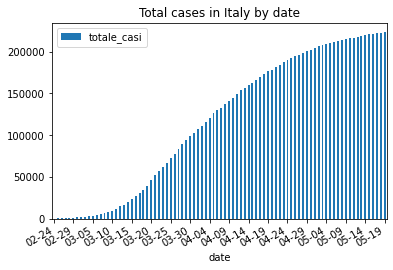

In [11]:
# plotting a graph showing day by day the number of total cases in Italy

# changing the dates for better readability 
# E.g. from the date '2020-05-17' the part involving the year is removed, leaving '05-17' as date
total_cases_by_date.rename(index=lambda s: s[5:], inplace=True)

ax = total_cases_by_date.plot(lw=2, title="Total cases in Italy by date", kind="bar")
ax.set_xlabel("date")

# sampling the dates on the ticks labels (printing a date label every 5 days)
xticks = ax.xaxis.get_major_ticks()
for i in range(len(xticks)):
    if i % 5 != 0:
        xticks[i].set_visible(False)

# set font and rotation for date tick labels
plt.gcf().autofmt_xdate()

TODO eventualmente trarre qualche conclusione sull'aspetto della curva.. è richiesto?

Another data that can be single out from the provinces data, is the number of cases in each province up to this moment.
For each province is located the max value of <code>totale_casi</code>, that is the number of cases in that province, up to now.

With no surprises the maximum number in the total cases in each province is from the last date available, since the number of <code>totale_casi</code>, is incremented each day. 

In [12]:
max_cases_per_province = refined_province_data.drop(columns=["lat", "long"]).groupby(['sigla_provincia']).max()
max_cases_per_province.head()

,data,denominazione_regione,denominazione_provincia,totale_casi
sigla_provincia,,,,
AG,2020-05-19,Sicilia,Agrigento,141
AL,2020-05-19,Piemonte,Alessandria,3807
AN,2020-05-19,Marche,Ancona,1867
AO,2020-05-19,Valle d'Aosta,Aosta,1175
AP,2020-05-19,Marche,Ascoli Piceno,290


As done before, a result obtained in a table can be presented with a graph. In order to keep simple the appearence of the graph, and avoid it to become excessively messy, only the top 15 provinces with most cases are shown. 

Text(0.5, 1.0, 'Top 15 provinces with most cases')

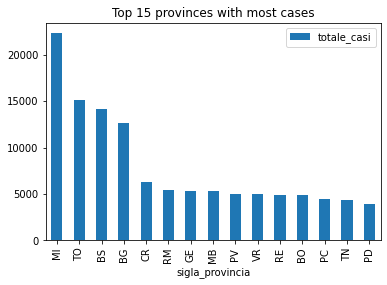

In [13]:
# Showing the top 15 provinces with the highest value on 'totale_casi'

max_cases_per_province.groupby(['sigla_provincia']).max().nlargest(15, 'totale_casi').plot(kind="bar")
plt.title("Top 15 provinces with most cases")

We could also be interested, in knowing the evolution of the distribution of total cases in the various provinces. Keeping this in mind we can collect the number of cases of each province per month and plot a pie chart to help us visualize that. 

As said before, in order to keep the view as clean as possible, we only enclose the provinces with most cases in the plot. 

As first thing is prepared the table that displays the number of cases of coronavirus per month, for each province. During this analysis are only taken into account the three months of March, April and May.

In [14]:
# creating a table with key the column sigla_provincia and data
sigla_provincia_table = refined_province_data.set_index(["sigla_provincia","data"])

# Get the provinces name in terms of sigla_provincia
provinces = refined_province_data.set_index("sigla_provincia").index.unique(level=0)

# Create a DataFrame with total cases per month for each province
cases_per_month = {}

# iterating through the provinces and setting the max cases per month in the proper dictionary
for province in provinces: 
    province_info = sigla_provincia_table.loc[province]
    # The 'groupby(province_info.data.str[:7]' is used to group the rows according to the month
    # The [:7] is used to slice the first 7 letters of the 'data' column
    # 2020-05-15 ---> 2020-05
    # And finally we take the max from 'totale_casi' per each province, each month
    cases_per_month[province] = pd.Series(province_info.groupby(province_info.index.str[:7])['totale_casi'].max())

# Create the DataFrame using the Series defined in the for loop
cpm = pd.DataFrame(cases_per_month)
cpm = cpm.T # For a better view

# the February column is not of our interest. The data collected during this month is not enough to obtain a proper
# analysis 
cpm = cpm.drop(columns=['2020-02'])
cmp = cpm.sort_index()

# showing below the new table of cases per month.
cmp.head()

data,2020-03,2020-04,2020-05
AG,94,135,141
AL,1317,3417,3807
AN,1116,1810,1867
AO,628,1128,1175
AP,222,281,290


Now that the table is ready we can plot the result in two different ways: with a bar chart, and a pie chart. While on both cases, we are showing the total cases for the months considered, per province, in the first case we show a more quantitative result.

The pie charts express more the comparison between provinces for the number of total cases.

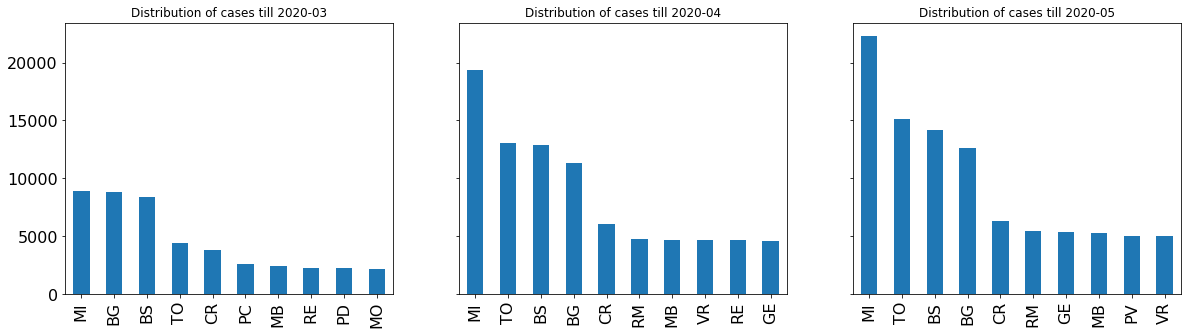

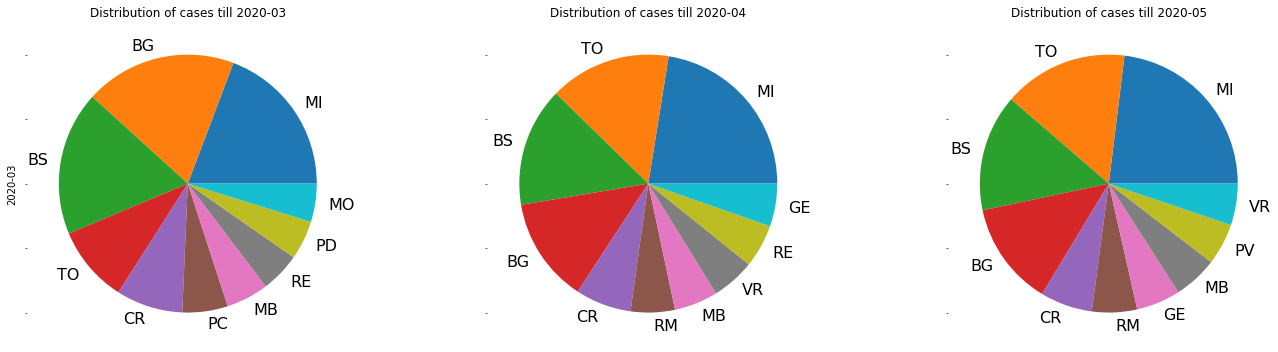

In [15]:
grid_size = (1,3) # For the 3 months considered

for plot_type in ['bar', 'pie']:
    fig, axes = plt.subplots(nrows=grid_size[0], ncols=grid_size[1], sharey=True, figsize=(20,5))
    cities_with_worst_cases = [] # Store the name of the cities with the worst cases

    month = 0
    w_cases_pm = [] # worst cases per month -> it will be used for the 'Total number of cases' plot
    for i in range(grid_size[0]):
        for j in range(grid_size[1]):
            # Cities twith the worst cases in the current month
            worst_cases = cpm.nlargest(10, cpm.columns[month])[cpm.columns[month]] # Top 10
            w_cases_pm.append(worst_cases)
            worst_cases.plot(ax=axes[month], kind=plot_type, 
                             legend=False,
                             fontsize=16)
            axes[month].set_title('Distribution of cases till '+cpm.columns[month])
            cities_with_worst_cases.append(worst_cases)
            month += 1
        
fig.tight_layout()

It can also be shown a graph that displays the trend of total cases, day by day for the most infected provinces. To keep the graph simple, like always are not shown all the provinces. In this case are only presented the eight worst. 

On the x-axis is placed the passing of days, and the vertical bar, labeled as <code>Lockdown</code> is put to indicate the beginning of the effects provoked by the lockdown enforced by the government. On the other hand, all the shaded red area indicates the period of the lockdown in Italy.

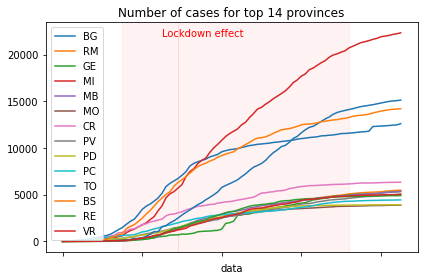

In [16]:
dati = refined_province_data.set_index(["sigla_provincia", "data"]).sort_index()

# Create a set of the cities with the highest cases 
interested_city = list(set([item for sublist in [list(city.index) for city in cities_with_worst_cases] for item in sublist]))

# Collect information about these cities day by day
for i in range(len(interested_city)):
    dati.loc[interested_city[i]]['totale_casi'].plot(
        kind='line', 
        label=interested_city[i], 
        title="Number of cases for top 14 provinces").set_xticklabels([])    

plt.text(25, 22000, "Lockdown effect", color="r")
plt.axvspan(15, 29, color='red', alpha=0.05)
plt.axvspan(29, 72, color='red', alpha=0.05)
plt.tight_layout()
plt.legend()

To help us visualize the spread of the virus through the provinces, we could also draw a map of Italy and highlight the provinces with dots with a different coloring depending on the number of cases per province. 
We have selected four different days to show the evolution of the desease.

In order to do this we used the library [GeoPandas](https://geopandas.org/) in addition to a [daset](http://www.diva-gis.org/gdata) of geological data of Italy, that could help us plot the whole country.
Different shapely files were available, with differents level of details. We used a <code>.shp</code> file with regional informations in order to keep the view simple.

We will now describe step by step how to plot the described view, starting from the loading of the geological data file.

In [17]:
# set the filepath of the file, and load in a shapefile
fp = "shape-italy/ITA_adm1.shp"
map_df = gpd.read_file(fp)

# we drop some of the columns of the dataset, that are not useful to us
map_df = map_df.drop(columns=["VARNAME_1", "TYPE_1", "ID_1", "ENGTYPE_1", "NL_NAME_1", "ISO", "ID_0", "NAME_0"])
map_df.head()

,NAME_1,geometry
0,Abruzzo,"POLYGON ((13.91542 42.89561, 13.91542 42.89542..."
1,Apulia,"MULTIPOLYGON (((17.94931 40.05375, 17.94931 40..."
2,Basilicata,"MULTIPOLYGON (((15.71736 39.96792, 15.71736 39..."
3,Calabria,"MULTIPOLYGON (((15.80208 39.70014, 15.80208 39..."
4,Campania,"MULTIPOLYGON (((14.25264 40.54153, 14.25264 40..."


As we can see, the <code>map_df</code> table holds, for each region, a polygon, or multipolygon, that gives us the informations on how to outline the specific region. We can already plot this table to see what it looks like. 

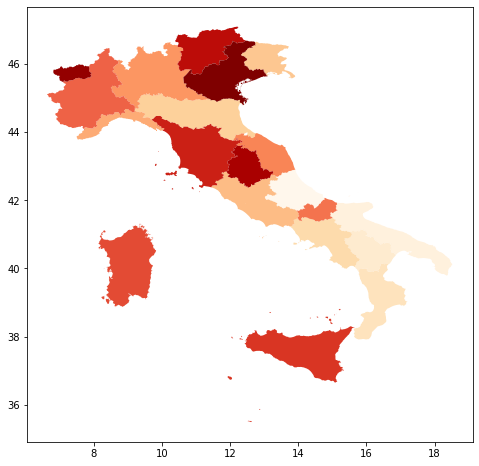

In [18]:
with plt.rc_context({"figure.figsize": [12,8]}):
    map_df.plot(cmap='OrRd')

Now that we have our base map we have to plot on it, the dots representative of the provinces data. For this reason, we are interested in having a table that selects latitude and longitude data together with the number of total cases per day. 

However, as said before, we only want to plot four representative days, in order to show the evolution of the spread of the virus through provinces. The newly created table <code>density_data</code> takes into consideration this idea.

In [19]:
density_data_p = refined_province_data[refined_province_data['data'].isin(['2020-02-24','2020-02-28', '2020-03-12', '2020-05-19'])].drop(
    columns=["denominazione_regione"]).set_index(
    ["data", "denominazione_provincia"]).sort_index()
density_data_p.head()


sigla_provincia        lat       long  \
data       denominazione_provincia                                         
2020-02-24 Agrigento                            AG  37.309711  13.584575   
           Alessandria                          AL  44.912974   8.615401   
           Ancona                               AN  43.616760  13.518875   
           Aosta                                AO  45.737503   7.320149   
           Arezzo                               AR  43.466428  11.882288   

                                    totale_casi  
data       denominazione_provincia               
2020-02-24 Agrigento                          0  
           Alessandria                        0  
           Ancona                             0  
           Aosta                              0  
           Arezzo                             0

Before merging the two data, from the map and the provinces, we have to make sure that the coordinate reference system is the same for both data. For latitude and longitude points we use the following crs. 

From the <code>density_data</code> we also extract the geometrical positions of the provinces, using the latitude and longitude data. Here is reported the result for some of the points obtained.

In [20]:
crs = CRS("epsg:4326")
geometry = [Point(xy) for xy in zip(density_data_p['long'], density_data_p['lat'])]
# plotting some points
geometry[:3]

It's now time to combine the two data: the points and the provinces data, by creating a GeoDataFrame.

In [21]:
geo_df= gpd.GeoDataFrame(density_data_p, crs = crs, geometry = geometry)
geo_df.head()

sigla_provincia        lat       long  \
data       denominazione_provincia                                         
2020-02-24 Agrigento                            AG  37.309711  13.584575   
           Alessandria                          AL  44.912974   8.615401   
           Ancona                               AN  43.616760  13.518875   
           Aosta                                AO  45.737503   7.320149   
           Arezzo                               AR  43.466428  11.882288   

                                    totale_casi                   geometry  
data       denominazione_provincia                                          
2020-02-24 Agrigento                          0  POINT (13.58457 37.30971)  
           Alessandria                        0   POINT (8.61540 44.91297)  
           Ancona                             0  POINT (13.51888 43.61676)  
           Aosta                              0   POINT (7.32015 45.73750)  
           Arezzo                             0  POINT (11.88229 43.46643)

Now that we have all the informations required, we can proceed to the plotting, by dividing the area into four sub-plots, one for each day, and representing with different colors a major or minor number of total cases per province.

TODO: trovare il modo di mettere se due righe i plot

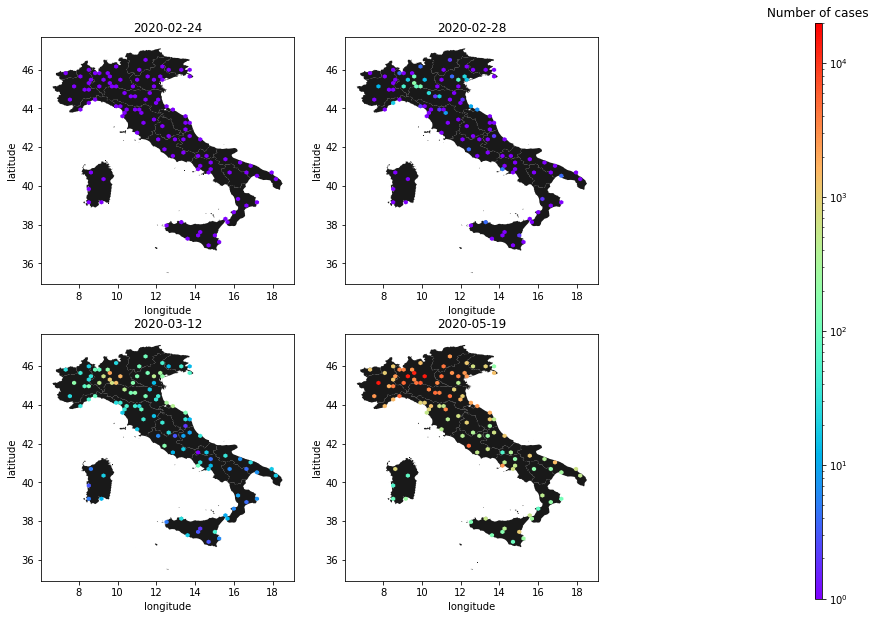

In [22]:
from matplotlib.colors import LinearSegmentedColormap

days = density_data_p.index.unique(level=0)
grid_size = (2,2) #four days
fig, axes = plt.subplots(nrows=grid_size[0], ncols=grid_size[1], figsize=(10,10))

r, c = (0,0)
for i, day in enumerate(range(len(days))):
    rowData = geo_df.loc[ days[i] , : ]
    totale_casi_per_data=rowData['totale_casi']
    x=rowData['long']
    y=rowData['lat']
    
    axes[r,c].set_title(days[i])
    axes[r,c].set_xlabel("longitude")
    axes[r,c].set_ylabel("latitude")
    
    map_df.plot(ax=axes[r,c], alpha=0.9, color="black")
    im = axes[r,c].hexbin(x,y, C=totale_casi_per_data, bins='log', edgecolors=None, cmap='rainbow', vmin=1., vmax=20000, gridsize=50)
    
    # Calculate the next subplot's indexes
    c = (c+1)%grid_size[1]
    if c == 0:
        r+=1
        
# Color bar
cbar_ax = fig.add_axes([1.2, 0.1, 0.01, 0.8])
cbar_ax.set_title('Number of cases')
fig.colorbar(im, cax=cbar_ax)
plt.show()

We could also display a distribution of cities with total number of cases above a certain threshold. The threshold is placed at 1000 cases. The code to get to this result is shown below.

Fixed 'till this point, provinces

Text(30.375, 0.5, 'Distribution of cases')

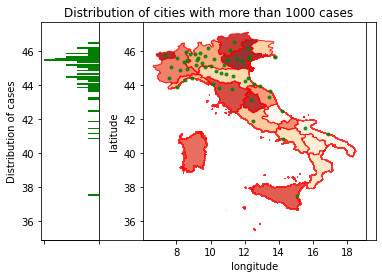

In [23]:
threshold = 1000
max_cases_per_province = refined_province_data.groupby(['sigla_provincia']).max()
days = density_data_p.index.unique(level=1)
cases_threshold = max_cases_per_province['totale_casi'] >= threshold
threshold_cases_df = max_cases_per_province[cases_threshold]

x = threshold_cases_df['long'] # longitude
y = threshold_cases_df['lat'] # latitude

# Set up the axes with gridspec
fig = plt.figure(figsize=(6, 4), constrained_layout=False)
plt.title("Distribution of cities with more than "+str(threshold)+" cases")
grid = plt.GridSpec(4, 4, hspace=0.6, wspace=0.6)
plt.xticks([])
plt.yticks([])

y_hist = fig.add_subplot(grid[:, 0], xticklabels=[])
main_ax = fig.add_subplot(grid[:, 1:], sharey=y_hist)
main_ax.set_xlabel("longitude")
main_ax.set_ylabel("latitude")
# Italy0s background
map_df.plot(ax=main_ax, alpha=0.8, edgecolor="red", cmap='OrRd')
# scatter points on the main axes
main_ax.plot(x, y, 'ok', markersize=3, alpha=0.8, color='green')
# histogram on the attached axes
y_hist.hist(y, 90, histtype='stepfilled', orientation='horizontal', color='green')
y_hist.invert_xaxis()
y_hist.set_ylabel("Distribution of cases")

## Region Analysis

As already seen with the provinces data, the first thing we want to show, is how the raw data from the region file is presented to us, with just a few adjustments. 

The modifications adopted are the following:

- As before is created a DataFrame <code>refined_region_data</code> in which some unnecessary columns are dropped,
- Also, just as with the province data, the date is reformatted cropping out useless data,
- Some of the data related, for example, to the column <code>casi_testati</code>, are not available and displayed as <code>NaN</code>. For better working with the data, we prefer to handle this kind as missing data by replacing it with 0.

The result of this operations is reported below.

In [24]:
# loding into a DataFrame the regions data as is
region_data = pd.DataFrame(covid19_regions_data)

# performing the few modifications listed above
#refined_region_data = region_data[province_data.denominazione_provincia!= "In fase di definizione/aggiornamento"].drop(columns=["note_it", "note_en", "codice_provincia", "codice_regione", "stato"])
refined_region_data = region_data.drop(columns=["stato", "note_en", "note_it", "lat", "long", "codice_regione"])

# for each date value is cropped the ending, leaving only the structure year-month-day.
# E.g. from the original date '2020-02-24T18:00:00' the result is simply '2020-02-24'
refined_region_data['data'] = refined_region_data['data'].map(lambda a: a[:10])

# we want to handle missing data as 0
refined_region_data = refined_region_data.fillna(0)
refined_region_data.fillna(0).head()


,data,denominazione_regione,ricoverati_con_sintomi,terapia_intensiva,totale_ospedalizzati,isolamento_domiciliare,totale_positivi,variazione_totale_positivi,nuovi_positivi,dimessi_guariti,deceduti,totale_casi,tamponi,casi_testati
0,2020-02-24,Abruzzo,0,0,0,0,0,0,0,0,0,0,5,0.0
1,2020-02-24,Basilicata,0,0,0,0,0,0,0,0,0,0,0,0.0
2,2020-02-24,P.A. Bolzano,0,0,0,0,0,0,0,0,0,0,1,0.0
3,2020-02-24,Calabria,0,0,0,0,0,0,0,0,0,0,1,0.0
4,2020-02-24,Campania,0,0,0,0,0,0,0,0,0,0,10,0.0


For the next computations we are interested in using as index for the region table, the column <code>denominazione_regione</code> and <code>data</code>. Also the records are sorted according to both index.

In [25]:
regions_data_frame = refined_region_data.set_index(["denominazione_regione", "data"]).sort_index()
regions_data_frame.head()

ricoverati_con_sintomi  terapia_intensiva  \
denominazione_regione data                                                    
Abruzzo               2020-02-24                       0                  0   
                      2020-02-25                       0                  0   
                      2020-02-26                       0                  0   
                      2020-02-27                       1                  0   
                      2020-02-28                       1                  0   

                                  totale_ospedalizzati  \
denominazione_regione data                               
Abruzzo               2020-02-24                     0   
                      2020-02-25                     0   
                      2020-02-26                     0   
                      2020-02-27                     1   
                      2020-02-28                     1   

                                  isolamento_domiciliare  totale_positivi  \
denominazione_regione data                                                  
Abruzzo               2020-02-24                       0                0   
                      2020-02-25                       0                0   
                      2020-02-26                       0                0   
                      2020-02-27                       0                1   
                      2020-02-28                       0                1   

                                  variazione_totale_positivi  nuovi_positivi  \
denominazione_regione data                                                     
Abruzzo               2020-02-24                           0               0   
                      2020-02-25                           0               0   
                      2020-02-26                           0               0   
                      2020-02-27                           1               1   
                      2020-02-28                           0               0   

                                  dimessi_guariti  deceduti  totale_casi  \
denominazione_regione data                                                 
Abruzzo               2020-02-24                0         0            0   
                      2020-02-25                0         0            0   
                      2020-02-26                0         0            0   
                      2020-02-27                0         0            1   
                      2020-02-28                0         0            1   

                                  tamponi  casi_testati  
denominazione_regione data                               
Abruzzo               2020-02-24        5           0.0  
                      2020-02-25        5           0.0  
                      2020-02-26       13           0.0  
                      2020-02-27       33           0.0  
                      2020-02-28       33           0.0

Below we want to show a quick view on the data gathered, for just a few regions, taken as sample. In order to do so, are taken into account seven regions, the most representative. 

The plots are organized in different subplots. Each subplot indicates a different area of interest, while highlighting the differences between regions represented as different lines.
Particular interest is placed on ephasize the transition from the period pre-lockdown, to post-lockdown. 

The red shaded area is the period of our interest. In particular, the transparent area starts at the moment of the lockdown. Because we care about knowing the effects of the quarantine after the first 14 days, the red vertical line indicates the moment after the passing of this amount of days. 

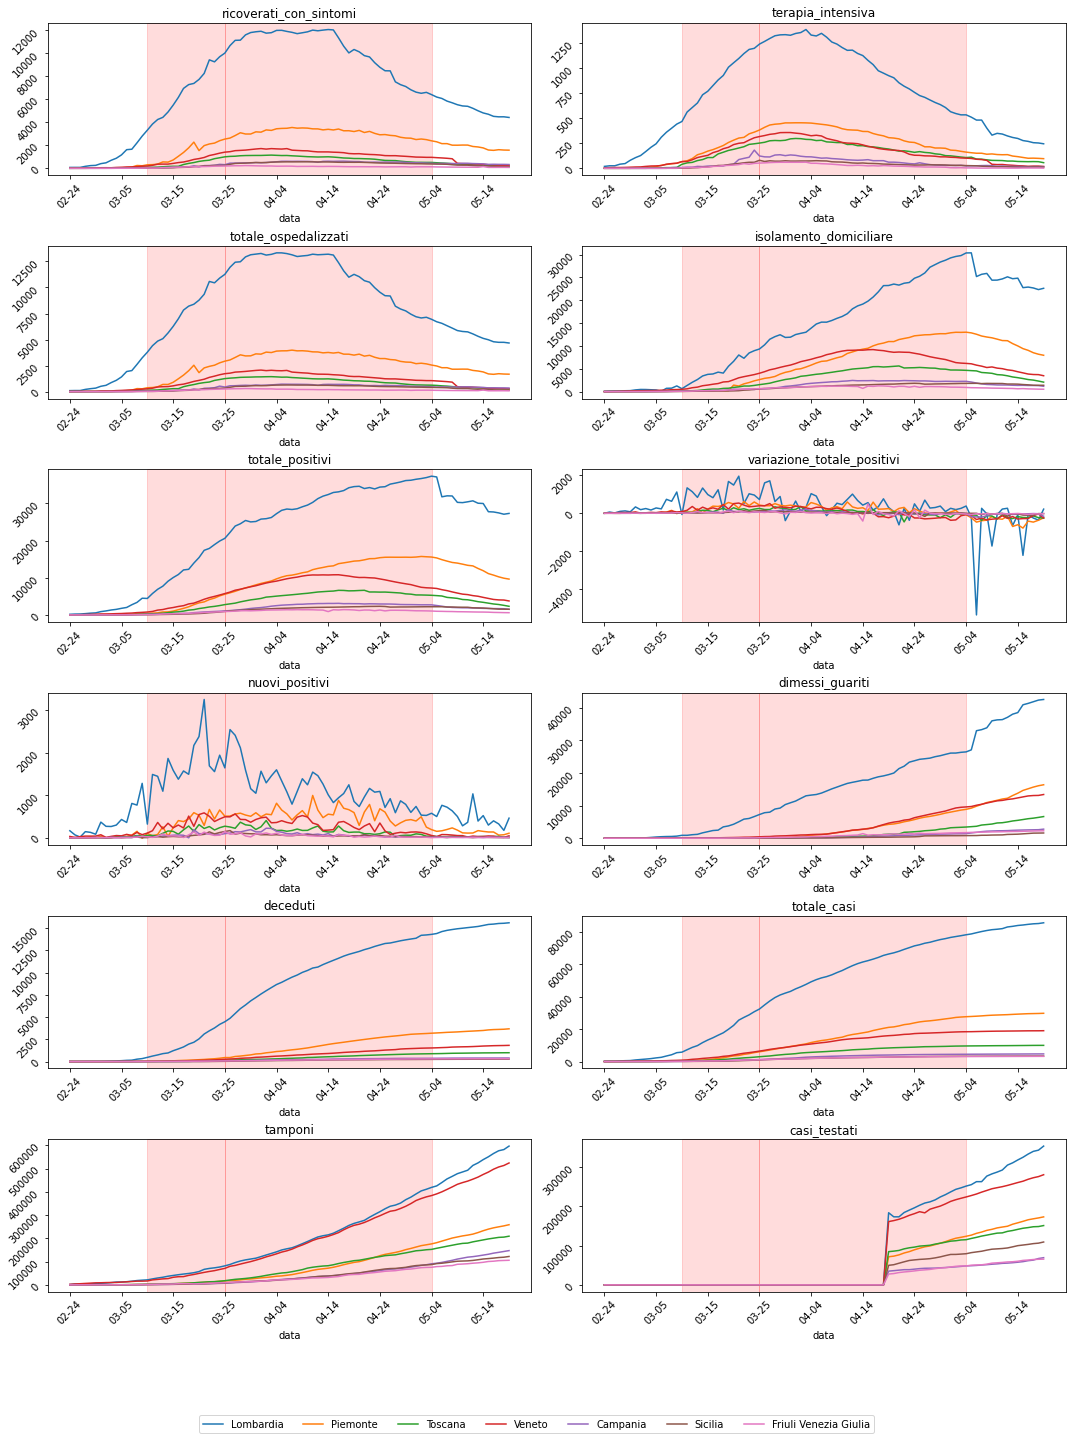

In [26]:
regions_considered = ['Lombardia', 'Piemonte', 'Toscana', 'Veneto', 'Campania', 'Sicilia', 'Friuli Venezia Giulia']
grid_size = (6, 2) # (#regions x #columns's info)
fig, axes = plt.subplots(nrows=grid_size[0], ncols=grid_size[1], sharex=False, figsize=(15,20))

i = 0
r, c = (0,0)
x_labels = regions_data_frame.index.unique(level=1)
x_labels = [elem[5:10] for elem in x_labels] # take only the month and the day, cut off the rest
for column_info in regions_data_frame.columns:
    for region in regions_considered:
        regions_data_frame.loc[region][column_info].plot(ax=axes[r,c], kind='line', title=column_info)
        axes[r,c].axvspan(15, 30, color='red', alpha=0.02) # Start of lockdown
        axes[r,c].axvspan(30, 70, color='red', alpha=0.02) # Lockdown's effects after 14 days
        # Calculate the xlabels for each subplot
        plt.sca(axes[r, c])
        plt.xticks(range(len(x_labels)), x_labels)
        xticks = axes[r,c].xaxis.get_major_ticks()
        for i in range(len(xticks)):
            if i % 10 != 0:
                xticks[i].set_visible(False)
        axes[r,c].tick_params(labelrotation=45)
        
    # Calculate the next subplot's indexes
    c = (c+1)%grid_size[1]
    if c == 0:
        r+=1
        
plt.tight_layout()
fig.subplots_adjust(bottom=0.1)
fig.legend(labels=regions_considered, loc="lower center", ncol=len(regions_considered))

## Province and Region Analysis

We could also discuss about information obtained by the merging of two datasets. In this case, the province and region data.

In the following graph we only take into consideration the last day available. For each region is shown, using a color, the total number of cases of coronavirus at that day. Also, each province is represented by a dot with a different coloring, as we have done already for the graph above. 

Because we have to deal with differents coordinate reference systems we re-define the crs and start to build our table.

In [27]:
crs = CRS("epsg:4326")
# extract latitude and longitude data from the last date available, along with the total cases (that are at its max)
provinces_data_per_latitude_longitude = refined_province_data.drop(columns=["denominazione_regione", "sigla_provincia"]).groupby(["denominazione_provincia"]).max()
provinces_data_per_latitude_longitude.head()

,data,lat,long,totale_casi
denominazione_provincia,,,,
Agrigento,2020-05-19,37.309711,13.584575,141
Alessandria,2020-05-19,44.912974,8.615401,3807
Ancona,2020-05-19,43.616760,13.518875,1867
Aosta,2020-05-19,45.737503,7.320149,1175
Arezzo,2020-05-19,43.466428,11.882288,674


This time we select as points a structure of the form <code>(longitude, latitude, totale_casi)</code>

In [28]:
geometry = [Point(xy) for xy in zip(provinces_data_per_latitude_longitude['long'], provinces_data_per_latitude_longitude['lat'], provinces_data_per_latitude_longitude['totale_casi'])]
geometry[:3]

We can now create our GeoDataFrame using this points.

In [29]:
# creating the GeoDataFrame using this points
geo_df= gpd.GeoDataFrame(provinces_data_per_latitude_longitude, crs = crs, geometry = geometry)
geo_df.head()

,data,lat,long,totale_casi,geometry
denominazione_provincia,,,,,
Agrigento,2020-05-19,37.309711,13.584575,141,POINT Z (13.58457 37.30971 141.00000)
Alessandria,2020-05-19,44.912974,8.615401,3807,POINT Z (8.61540 44.91297 3807.00000)
Ancona,2020-05-19,43.616760,13.518875,1867,POINT Z (13.51888 43.61676 1867.00000)
Aosta,2020-05-19,45.737503,7.320149,1175,POINT Z (7.32015 45.73750 1175.00000)
Arezzo,2020-05-19,43.466428,11.882288,674,POINT Z (11.88229 43.46643 674.00000)


We now make some modifications upon the regional data, taking into consideration only the last date available, that is in our interest. We also combine the total cases of Trento and Bolzano.

In [30]:
# loding into a DataFrame the regions data as is
regions_data = pd.DataFrame(covid19_regions_data)

# for each date value is cropped the ending, leaving only the structure year-month-day.
# E.g. from the original date '2020-02-24T18:00:00' the result is simply '2020-02-24'
regions_data['data'] = regions_data['data'].map(lambda a: a[:10])
regions_data = regions_data.drop(columns=['stato','codice_regione','note_it','note_en'])

# Here we take into consideration the desired date
regions_data_r = regions_data['data'] == '2020-05-19' # select the desired date
regions_data = regions_data[regions_data_r].set_index('denominazione_regione') # reset the index
trento_cases = regions_data.loc['P.A. Trento']['totale_casi'] # We will combine total cases of Trento and Bolzano
regions_data = regions_data.drop(['P.A. Trento'])
regions_data.head()

,data,lat,long,ricoverati_con_sintomi,terapia_intensiva,totale_ospedalizzati,isolamento_domiciliare,totale_positivi,variazione_totale_positivi,nuovi_positivi,dimessi_guariti,deceduti,totale_casi,tamponi,casi_testati
denominazione_regione,,,,,,,,,,,,,,,
Abruzzo,2020-05-19,42.351222,13.398438,188,6,194,1195,1389,-24,4,1419,389,3197,58945,41162.0
Basilicata,2020-05-19,40.639471,15.805148,26,1,27,57,84,-9,1,282,27,393,23347,22767.0
P.A. Bolzano,2020-05-19,46.499335,11.356624,46,6,52,256,308,1,5,1988,291,2587,55526,25263.0
Calabria,2020-05-19,38.905976,16.594402,50,2,52,330,382,-19,2,676,95,1153,57310,55270.0
Campania,2020-05-19,40.839566,14.250850,330,17,347,1171,1518,-155,12,2790,399,4707,147225,69264.0


We can now proceed on merging the data from the region, the provinces, already combined with the geological data. Since we have different region's name (and order) in the <code>map_df</code> and <code>regions_data</code> DataFrame we need to shift and combine some values manually.

We also merge the total cases of Trento and Bolzano. 

In [31]:
# shifting and combining
totale_casi = list(regions_data['totale_casi'])
totale_casi.insert(1, totale_casi.pop(13))
totale_casi.insert(16, totale_casi.pop(3))
totale_casi[16] += trento_cases # Total cases of Trento + Bolzano 
map_df['totale_casi'] = totale_casi # Add 'toale_casi' column to the GeoDataFrame map_df
map_df.head()

,NAME_1,geometry,totale_casi
0,Abruzzo,"POLYGON ((13.91542 42.89561, 13.91542 42.89542...",3197
1,Apulia,"MULTIPOLYGON (((17.94931 40.05375, 17.94931 40...",4396
2,Basilicata,"MULTIPOLYGON (((15.71736 39.96792, 15.71736 39...",393
3,Calabria,"MULTIPOLYGON (((15.80208 39.70014, 15.80208 39...",1153
4,Campania,"MULTIPOLYGON (((14.25264 40.54153, 14.25264 40...",4707


It's time to work on the plot. The code below is divided into two blocks. First we handle regional data, displaying a different color for different number of cases to the last day available. The same is done for the provinces data. 


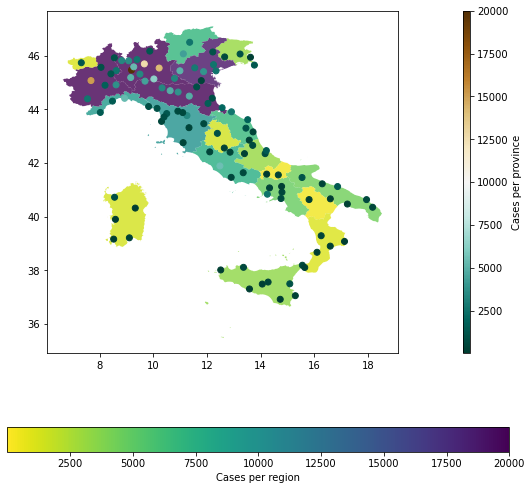

In [32]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig,ax= plt.subplots(figsize=(9,9))

divider = make_axes_locatable(ax)
cax_province = divider.append_axes("right", size="2%", pad=0.9)

# Region
map_df.plot(ax=ax, alpha=0.8,            
            column='totale_casi', 
            cmap='viridis_r', 
            legend=True,
            vmin=1, 
            vmax=20000,
            legend_kwds={'label': "Cases per region",
                         'orientation': "horizontal"})
# Province
geo_df.plot(ax=ax, column='totale_casi', cmap='BrBG_r', 
            facecolor="none", 
            edgecolors=None, 
            legend=True,
            vmin=1, 
            vmax=20000,
            cax=cax_province,
            legend_kwds={'label': "Cases per province"})